## Testing a trained mobilenet SSD

This notebook shows my process in using a trained SSD model to perform object detection and also processing the project video 

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, GlobalAveragePooling2D
from keras.layers import  Flatten, Reshape, Concatenate, Activation, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LambdaCallback
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.applications.mobilenet import _depthwise_conv_block, _conv_block

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
# from moviepy.editor import VideoFileClip
import numpy as np
import pandas as pd
import cv2
import glob

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.measurements import label as sklabel
import time
from moviepy.editor import VideoFileClip

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [3]:
# these are the classes the network predict -- the background class plus those in the udacity dataset-- 
#the relevant ones will be car and truck
udacity_traffic_classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

### Model definition

This is not needed if using Kera's `load_model` option, otherwise, define the model as per below, then use `model.load_weights`

In [4]:
def mobilenet_model(image_shape, n_classes, input_shape=(128,128,3), l2_reg=0.0, 
                    scales = [0.08, 0.16, 0.32, 0.64, 0.96],
                  variances = np.array([1.0, 1.0, 1.0, 1.0]),
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]]):
    n_predictor_layers = 4 # The number of predictor conv layers in the network
    n_classes += 1 # Account for the background class.
    # one box per aspect ratio, so for a predictor layer with 3 ratios then 3 boxes
    n_boxes = []
    scales = scales # for anchor boxes 
    variances = variances
    steps = [None] * n_predictor_layers
    offsets = [None] * n_predictor_layers
    
    for i in aspect_ratios_per_layer:
        n_boxes.append(len(i))
        
    alpha=1.0
    depth_multiplier=1
    dropout=1e-3
    
    img_height = input_shape[0]
    img_width = input_shape[1]
        
    x = Input(shape=image_shape)
    x1 = Lambda(lambda x: K.tf.image.resize_images(x, (input_shape[0], input_shape[1])))(x)
    x1 = Lambda(lambda x: x - np.array(127.5), output_shape=input_shape,
                   name='input_mean_norm')(x)
    x1 = Lambda(lambda x: x/np.array(127.5), output_shape=input_shape,
                   name='input_scaler')(x1)
    
    conv = _conv_block(x1, 32, alpha, strides=(2, 2))
    d1 = _depthwise_conv_block(conv, 64, alpha, depth_multiplier, block_id=1)

    d2 = _depthwise_conv_block(d1, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    d3 = _depthwise_conv_block(d2, 128, alpha, depth_multiplier, block_id=3)

    d4 = _depthwise_conv_block(d3, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    d5 = _depthwise_conv_block(d4, 256, alpha, depth_multiplier, block_id=5)

    d6 = _depthwise_conv_block(d5, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    d7 = _depthwise_conv_block(d6, 512, alpha, depth_multiplier, block_id=7)
    d8 = _depthwise_conv_block(d7, 512, alpha, depth_multiplier, block_id=8)
    d9 = _depthwise_conv_block(d8, 512, alpha, depth_multiplier, block_id=9)
    d10 = _depthwise_conv_block(d9, 512, alpha, depth_multiplier, block_id=10)
    d11 = _depthwise_conv_block(d10, 512, alpha, depth_multiplier, block_id=11)

    d12 = _depthwise_conv_block(d11, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    d13 = _depthwise_conv_block(d12, 1024, alpha, depth_multiplier, block_id=13)
    
    
    classes4 = Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes4')(d10)
    classes5 = Conv2D(n_boxes[1] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes5')(d11)
    classes6 = Conv2D(n_boxes[2] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes6')(d12)
    classes7 = Conv2D(n_boxes[3] * n_classes, (3, 3), strides=(1, 1), padding="same", 
                      kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                      name='classes7')(d13)
    
    
    # 4 coords per box -- xmin, xmax, ymin, ymax
    box4 = Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box4')(d10)
    box5 = Conv2D(n_boxes[1] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box5')(d11)
    box6 = Conv2D(n_boxes[2] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box6')(d12)
    box7 = Conv2D(n_boxes[3] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box7')(d13)
    
    
    #use the custom anchorbox layer to generate predictions for boxes
    anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios_per_layer[0],
                           two_boxes_for_ar1=False, this_steps=steps[0], this_offsets=offsets[0],
                           limit_boxes=False, variances=variances, coords='centroids', 
                           normalize_coords=False, name='anchors4')(box4)
    anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios_per_layer[1],
                           two_boxes_for_ar1=False, this_steps=steps[1], this_offsets=offsets[1],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors5')(box5)
    anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios_per_layer[2],
                           two_boxes_for_ar1=False, this_steps=steps[2], this_offsets=offsets[2],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors6')(box6)
    anchors7 = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios_per_layer[3],
                           two_boxes_for_ar1=False, this_steps=steps[3], this_offsets=offsets[3],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors7')(box7)
    
    
    # Reshape the class predictors tensor into (batch, height * width * n_boxes, n_classes) => the class is now the last variable for predcition
    classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
    classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
    classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)
    classes7_reshaped = Reshape((-1, n_classes), name='classes7_reshape')(classes7)
    
    # Reshape the box coords predictions, into tensors of shape (batch, height * width * n_boxes, 4) => box positions last for loss
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(box4)
    boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(box5)
    boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(box6)
    boxes7_reshaped = Reshape((-1, 4), name='boxes7_reshape')(box7)
    # Reshape the anchor box tensors, into tensors of shape (batch, height * width * n_boxes, 8)
    anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
    anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
    anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)
    anchors7_reshaped = Reshape((-1, 8), name='anchors7_reshape')(anchors7)
    #concat along the middle axis, since want to keep the batch and n_classes/8 untouched
    class_concat = Concatenate(axis=1, name='concatenate_classes')([classes4_reshaped, 
                                classes5_reshaped,classes6_reshaped, 
                                classes7_reshaped])
    boxes_concat = Concatenate(axis=1, name='concatenate_boxes')([boxes4_reshaped,
                                                             boxes5_reshaped,
                                                             boxes6_reshaped,
                                                             boxes7_reshaped])

    # Output shape of `anchors_final`: (batch, n_boxes_total, 8)
    anchors_concat = Concatenate(axis=1, name='concatenate_anchors')([anchors4_reshaped,
                                                                 anchors5_reshaped,
                                                                 anchors6_reshaped,
                                                                 anchors7_reshaped])
    
    classes_softmax = Activation('softmax', name='classes_softmax')(class_concat)
    
    prediction = Concatenate(axis=2,name='concatenate_output')([
                                                            classes_softmax,
                                                              boxes_concat,
                                                              anchors_concat ])
    
    model = Model(inputs=x, outputs=prediction)
    
    return model

In [21]:
# load the model, also pass the custom layers/loss functions into keras 
model_path = 'ssd7_train/ssd7_mobilenet_v1.h5'
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session()

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss, 
                                              'relu6': relu6, 'DepthwiseConv2D': DepthwiseConv2D})


### Testing the trained model on the images from the train/validation dataset 

In [7]:
udacity_traffic_images = glob.glob('udacity_driving_datasets/*.jpg')

In [8]:
np.random.shuffle(udacity_traffic_images)
predict_imgs = udacity_traffic_images[:6]
X = np.array([cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) for x in predict_imgs])
y_pred = model.predict(X)
y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.1,
                           iou_threshold=0.2,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=300,
                           img_width=480)


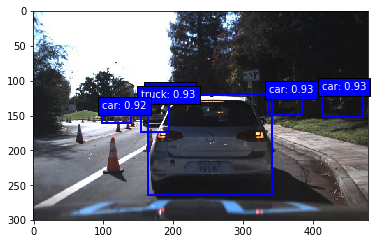

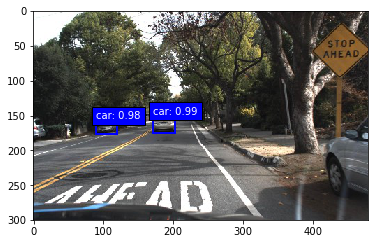

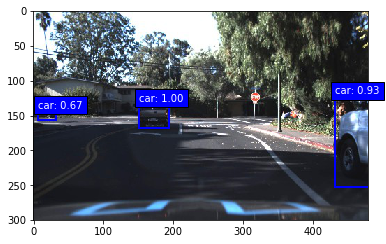

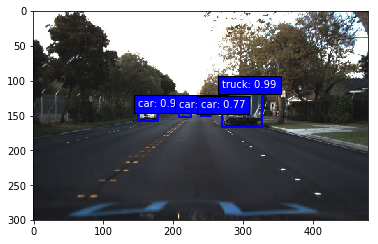

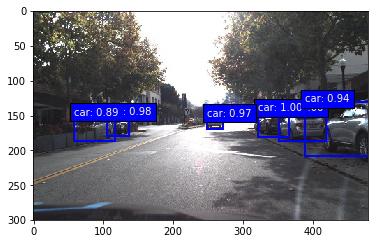

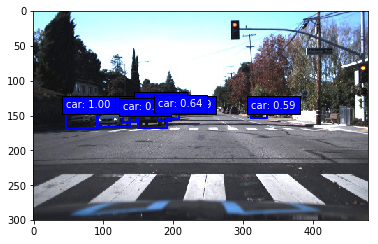

In [9]:
for i in range(len(y_pred_decoded)):
    plt.figure()
    plt.imshow(X[i])
    ax = plt.gca()
    # Draw the predicted boxes
    for box in y_pred_decoded[i]:
        xmin = box[-4]
        ymin = box[-3]
        xmax = box[-2]
        ymax = box[-1]
        #print predicted class + confidence
        label = '{}: {:.2f}'.format(udacity_traffic_classes[int(box[0])], box[1])
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
        ax.text(xmin, ymin, label,  color='white', bbox={'facecolor':'blue', 'alpha':1.0})
    plt.savefig('output_images/' + udacity_traffic_images[i].split('/')[1].split('.')[0] + '_predicted.jpg')

The above are a tiny subset of the training images wiht the annotations labels-- the network seems to have done a fairly decent job in detecting the cars. Now, the following tests how the network does on the test images which are more similar to those from the video

### Testing on the test images from project

In [10]:
test_imgs = glob.glob('test_images/*.jpg')
X2 = np.array([cv2.cvtColor(cv2.resize(cv2.imread(x), (480,300)), cv2.COLOR_BGR2RGB) for x in test_imgs])


In [11]:
y_pred2 = model.predict(X2)

In [12]:
y_pred2_decoded = decode_y(y_pred2,
                           confidence_thresh=0.5,
                           iou_threshold=0.1,
                           top_k=200,
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=300,
                           img_width=480)

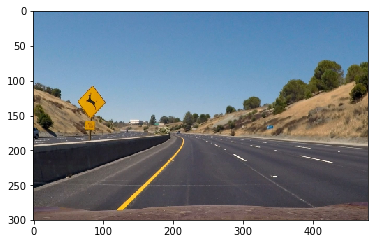

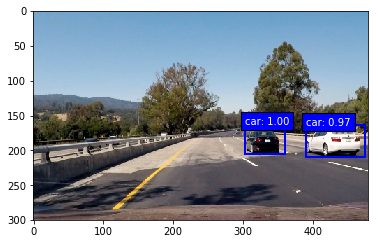

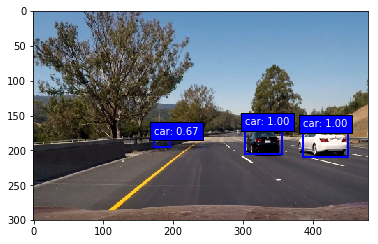

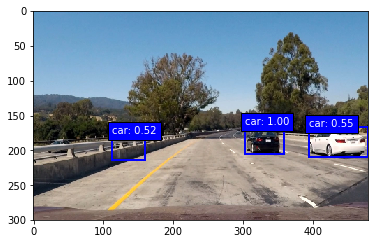

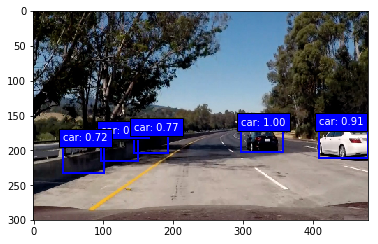

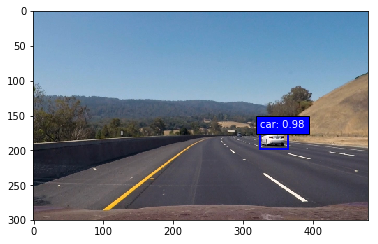

In [14]:
for i in range(len(y_pred2_decoded)):
    plt.figure()
    plt.imshow(X2[i])
    ax = plt.gca()
    # Draw the predicted boxes
    for box in y_pred2_decoded[i]:
        xmin = box[-4]
        ymin = box[-3]
        xmax = box[-2]
        ymax = box[-1]
        #print predicted class + confidence
        label = '{}: {:.2f}'.format(udacity_traffic_classes[int(box[0])], box[1])
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
        ax.text(xmin, ymin, label,  color='white', bbox={'facecolor':'blue', 'alpha':1.0})
    plt.savefig('output_images/' + test_imgs[i].split('/')[1].split('.')[0] + '_predicted.jpg')

The network has predicted where the cars are reasonably well, except that it has issues with the side railing on the left -- it thinks some of them are cars... This might be fixable with further training/tuning params in the network,
but for this project, I will reduce the number of false positivies by averaging over frames and only annotating boxes that occur on a large portion of these frames

### Video processing

In [25]:
# video processor class-- it saves a sequence of detected boxes and applies a 'heatmap' method over these to figure out
# which boxes should be included in the output video frames
class Processor:
    def __init__(self, img_height, img_width):
        self.bboxes = []
        self.img_height = img_height
        self.img_width = img_width
        
    def construct_heatmap(self,image, bounding_boxes, threshold = 0):
        heatmap = np.zeros_like(image[:,:,0])
        # Iterate through list of bboxes
        for box in bounding_boxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self,img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        return img
    
    # decode the output of the network to bounding boxes     
    def decode_to_boxes(self, prediction):
        bboxes = []
        y_pred_decoded = decode_y2(prediction,
                               confidence_thresh=0.5,
                               iou_threshold=0.1,
                               top_k='all',
                               input_coords='centroids',
                               normalize_coords=False,
                               img_height=300,
                               img_width=480)
        #dataset classes
        classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] 
        
        #Decoded predictions of boxes (is a list of [class_id, confidence, xmin, ymin, xmax, ymax])
        for box in y_pred_decoded[0]:
            #only use the annotation if it's a vehicle, ie car or truck
            if(box[0] == 1 or box[0] ==2):
            # Transform the predicted bounding boxes for the 300x480 image to the original image dimensions.
                xmin = box[2] * self.img_width / 480
                ymin = box[3] * self.img_height / 300
                xmax = box[4] * self.img_width/ 480
                ymax = box[5] * self.img_height/ 300
                bboxes.append(((np.int(xmin), np.int(ymin)), (np.int(xmax),np.int(ymax ))))
        return bboxes
    # actual function for moviepy to feed into, it does averaging over frames to reduce false positivies
    def movieprocessing(self, image):
        img_input = cv2.resize(image, (480, 300))
        prediction = model.predict(np.array([img_input]))
        bboxes = self.decode_to_boxes(prediction)
        self.bboxes.append(bboxes)
        #averaging over 25 frames, ie 1s of video
        if len(self.bboxes) > 25:
            boxes_to_avg = []
            self.bboxes = self.bboxes[-25:]
            for boxlist in self.bboxes:
                for box in boxlist:
                    boxes_to_avg.append(box)
            # construct heatmap of boxes, set the threshold for relevant pixels        
            heatmap = self.construct_heatmap(image, boxes_to_avg, threshold = 15)
            labels = sklabel(heatmap)
            return self.draw_labeled_bboxes(np.copy(image), labels)
            
        else:
            # for the 1s or so of the video, don't draw the boxes just yet 
            return image

In [26]:
video_processor = Processor(720, 1280)

video_output = 'ssd_mobilenet_output_averaging_v4_c-05-i-01.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip_out = clip1.fl_image(video_processor.movieprocessing)
%time clip_out.write_videofile(video_output, audio=False, progress_bar=False, verbose=False)

CPU times: user 6min 57s, sys: 26.4 s, total: 7min 23s
Wall time: 2min 39s


### Model performance:

Frames processed per second = wall time / frame rate

In [27]:
fps_network = 160 / clip1.fps
print('network processed video at {} fps'.format(fps_network))

network processed video at 6.4 fps
